In [1]:
using Rays

# A view of a cube

### The basic setup

In [2]:
# Define a camera
camera = Rays.Camera(1)
camera.screen_res[1] = [500, 500]

# Define a cube at the origin
cube = Rays.Cube(zeros(3), 1.0)

# Let the camera look towards the origin
from = [2.0, 2.0, 2.0]
to = zeros(3)
Rays.look_at!(camera, 1, from, to)

# Compute ray intersections with the cube
t_int, _ = Rays.shape_view(camera, 1, cube)

# Generate an image from the ray intersections
# The brightness drops off with the distance to the camera
canvas = Rays.cam_is_source(t_int)

# This stuff won't be needed in the future
canvas = transpose(canvas)
reverse!(canvas);

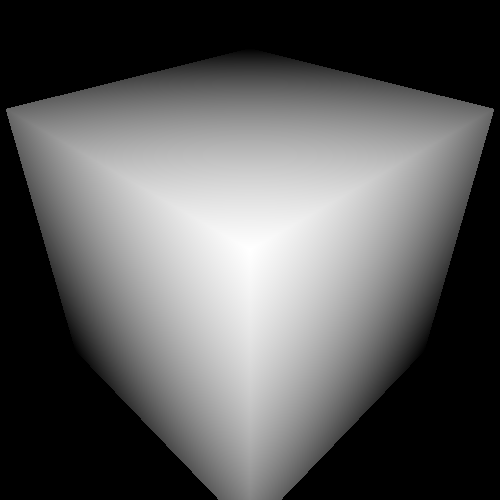

In [3]:
using Images: colorview, Gray

colorview(Gray, canvas)

### Adding color

In [4]:
# Get ray intersections while collecting the data of the intersection dimension
collect_metadata = Dict(:dim_int => Int)
t_int, metadata = Rays.shape_view(camera, 1, cube; collect_metadata)
dim_int = metadata[:dim_int]
screen_res = camera.screen_res[1]

# Assign the colors red, green, blue to the different intersection dimensions
color = zeros(3, screen_res...)
for i = 1:screen_res[1]
    for j = 1:screen_res[2]
        dim_int_ = dim_int[i, j]
        if !iszero(dim_int_)
            color[dim_int_, i, j] = 1.0
        end
    end
end

# Reproduce the image with this color information
canvas = Rays.cam_is_source(t_int; color)

# This stuff won't be needed in the future
canvas = permutedims(canvas, [1, 3, 2])
reverse!(canvas);

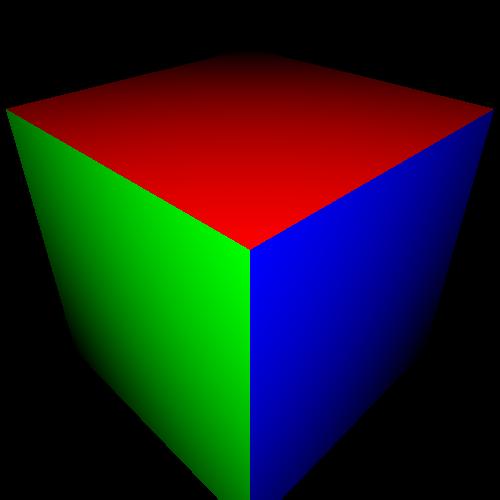

In [5]:
using Images: RGB, N0f8

canvas_RGB = RGB{N0f8}.([canvas[channel, :, :] for channel = 1:3]...)
colorview(RGB, canvas_RGB)

### Add depth of field

In [6]:
# This curve determines how the blurring depends on the distance to
# the camera
focus_curve(t) = 0.5 + 10 * abs(t - 3)

canvas = Rays.cam_is_source(t_int; color)
canvas = Rays.add_depth_of_field(canvas, t_int, focus_curve)

# This stuff won't be needed in the future
canvas = permutedims(canvas, [1, 3, 2])
reverse!(canvas);

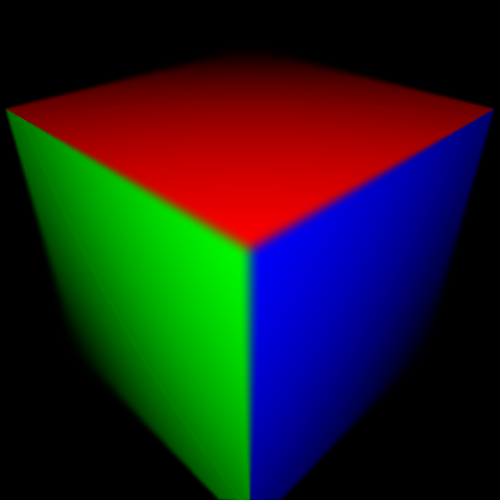

In [7]:
canvas_RGB = RGB{N0f8}.([canvas[channel, :, :] for channel = 1:3]...)
colorview(RGB, canvas_RGB)

### Replace the cube by a Menger sponge

In [8]:
# Get ray intersections while collecting the data of the intersection dimension
menger_sponge = Rays.Menger_sponge(zeros(3), 1.0, 3)
collect_metadata = Dict(:dim_int => Int)
t_int, metadata = Rays.shape_view(camera, 1, menger_sponge; collect_metadata)
dim_int = metadata[:dim_int]
screen_res = camera.screen_res[1]

# Assign the colors red, green, blue to the different intersection dimensions
color = zeros(3, screen_res...)
for i = 1:screen_res[1]
    for j = 1:screen_res[2]
        dim_int_ = dim_int[i, j]
        if !iszero(dim_int_)
            color[dim_int_, i, j] = 1.0
        end
    end
end

# Reproduce the image with this color information
canvas = Rays.cam_is_source(t_int; color)

# Add depth of add depth of field
canvas = Rays.add_depth_of_field(canvas, t_int, focus_curve)

# This stuff won't be needed in the future
canvas = permutedims(canvas, [1, 3, 2])
reverse!(canvas);

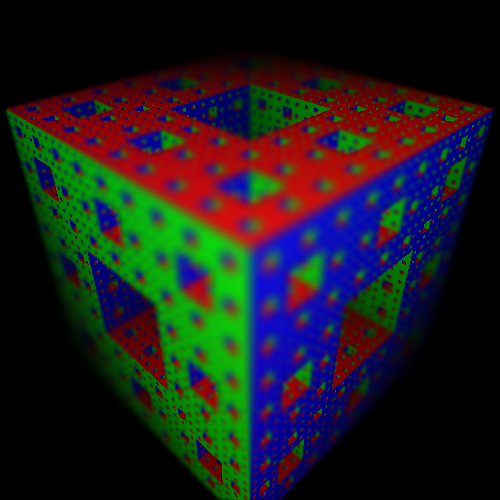

In [9]:
canvas_RGB = RGB{N0f8}.([canvas[channel, :, :] for channel = 1:3]...)
colorview(RGB, canvas_RGB)

### Add a camera warp

In [10]:
# Define warp function and assign it to the camera
function warp!(v)::Nothing
    v[3] = v[3] + 0.1 * sin(250 * v[2])
    v[1] = v[1] + 0.1 * sin(250 * v[2])
    return nothing
end
camera.warp[1] = warp!

# Get ray intersections while collecting the data of the intersection dimension
collect_metadata = Dict(:dim_int => Int)
t_int, metadata = Rays.shape_view(camera, 1, menger_sponge; collect_metadata)
dim_int = metadata[:dim_int]

# Assign the colors red, green, blue to the different intersection dimensions
color = zeros(3, screen_res...)
for i = 1:screen_res[1]
    for j = 1:screen_res[2]
        dim_int_ = dim_int[i, j]
        if !iszero(dim_int_)
            color[dim_int_, i, j] = 1.0
        end
    end
end

# Reproduce the image with this color information
canvas = Rays.cam_is_source(t_int; color)

# Add depth of add depth of field
canvas = Rays.add_depth_of_field(canvas, t_int, focus_curve)

# This stuff won't be needed in the future
canvas = permutedims(canvas, [1, 3, 2])
reverse!(canvas);

# Remove camera warp
camera.warp[1] = identity

identity (generic function with 1 method)

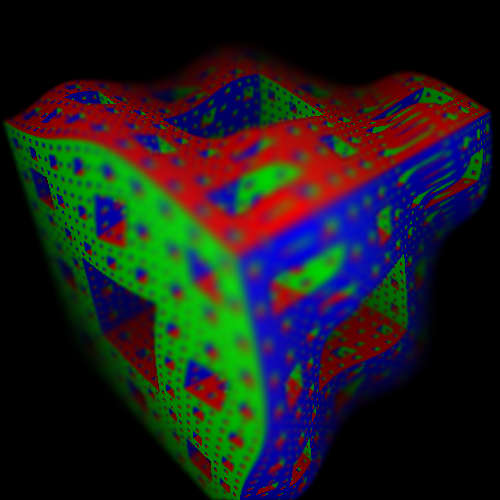

In [11]:
canvas_RGB = RGB{N0f8}.([canvas[channel, :, :] for channel = 1:3]...)
colorview(RGB, canvas_RGB)

# Available shapes

### Default

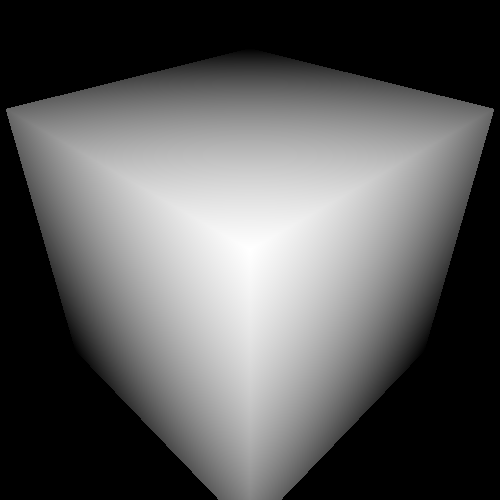

Rays.Cube

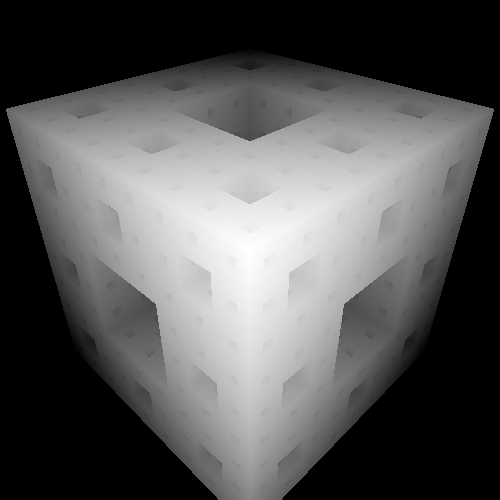


Rays.FractalShape{Rays.Cube}

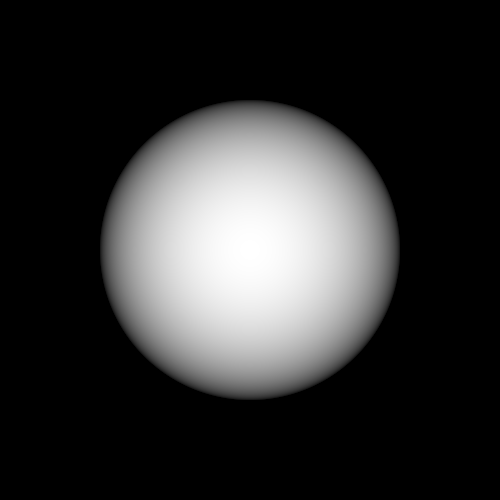


Rays.Sphere


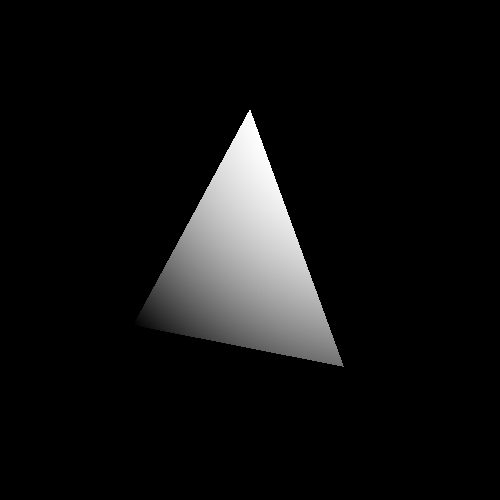

Rays.ConvexTriangleShape


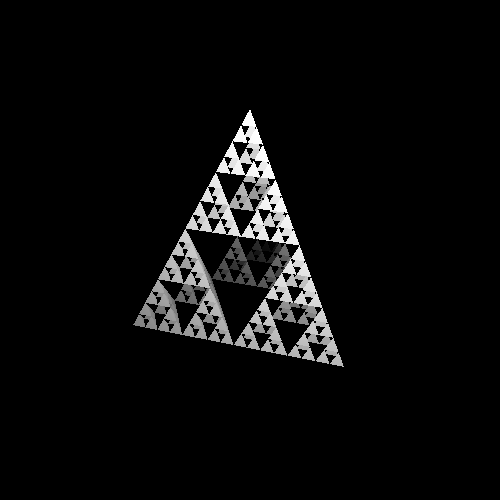

Rays.FractalShape{Rays.ConvexTriangleShape}


In [12]:
origin = zeros(3)
R = 1.0

shapes = [
    Rays.Cube(origin, R),
    Rays.Menger_sponge(origin, R, 3),
    Rays.Sphere(origin, R),
    Rays.Tetrahedron(origin, R),
    Rays.Sierpinski_pyramid(origin, R, 3)
]

function simple_view(shape)
    t_int, _ = Rays.shape_view(camera, 1, shape)
    canvas = Rays.cam_is_source(t_int)
    canvas = transpose(canvas)
    reverse!(canvas);
    println(typeof(shape))
    display(colorview(Gray, canvas))
end

for shape in shapes
    simple_view(shape)
end
    

### Custom

In [13]:
# Approximate a donut shape
R = 1.0
r = 0.3

n_θ = 5
n_ϕ = 5

n_vertices = n_θ * n_ϕ
n_faces = 2 * n_vertices

Θ = range(0, 2π, n_θ + 1)[1:end-1]
Φ = range(0, 2π, n_ϕ + 1)[1:end-1]

vertices = zeros(n_vertices, 3)
faces = zeros(2 * n_θ * n_ϕ, 3)

for (i, θ) in enumerate(Θ)
    for (j, ϕ) in enumerate(Φ) 

        vertex_idx_1 = (i - 1) * n_ϕ + j
        vertex_idx_2 = (i % n_θ) * n_ϕ + j
        vertex_idx_3 = (i - 1) * n_ϕ + j % n_ϕ + 1
        vertex_idx_4 = (i % n_θ) * n_ϕ + j % n_ϕ + 1

        vertices[vertex_idx_1, :] = [
            cos(θ) * (R + r*cos(ϕ)),
            sin(θ) * (R + r*cos(ϕ)),
            r * sin(ϕ)
        ]

        faces[vertex_idx_1, :] = [
            vertex_idx_1, 
            vertex_idx_2,
            vertex_idx_3,
        ]

        faces[n_vertices + vertex_idx_1, :] = [
            vertex_idx_4, 
            vertex_idx_2,
            vertex_idx_3,
        ]
    end
end

donut = Rays.GeneralTriangleShape(
    vertices, 
    faces, 
    origin, 
    n_vertices,
    n_faces)

# Generate a random color per face
face_colors = (1.0 .+ rand(n_faces, 3))/2
collect_metadata = Dict(:face_int => Int)
t_int, metadata = Rays.shape_view(camera, 1, donut; collect_metadata)
face_int = metadata[:face_int]

screen_res = camera.screen_res[1]
color = zeros(3, screen_res...)
for i in 1:screen_res[1]
    for j in 1:screen_res[2]
        face_int_ = face_int[i,j]
        if !iszero(face_int_)
            color[:,i,j] = face_colors[face_int_, :]
        end
    end
end

canvas = Rays.cam_is_source(t_int; color)

# This stuff won't be needed in the future
canvas = permutedims(canvas, [1, 3, 2])
reverse!(canvas);

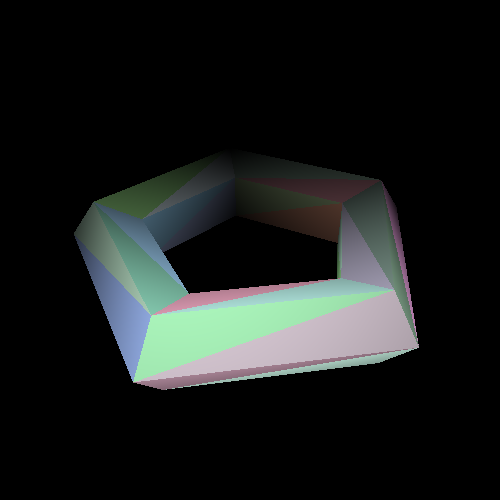

In [14]:
canvas_RGB = RGB{N0f8}.([canvas[channel, :, :] for channel = 1:3]...)
colorview(RGB, canvas_RGB)